In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

In [2]:
data_r = pd.read_pickle('Data\\classified_tweets\\repub_classified.pickle')
data_t = pd.read_pickle('Data\\classified_tweets\\trump_classified.pickle')

In [3]:
prc94 = round(data_t['user-followers_count'].astype(int).describe(percentiles=[.94]))['94%']
print('94 percentile:', prc94, 'followers')

94 percentile: 16039.0 followers


In [4]:
def data2idx(data, nfol=5000):
    df_ol = data[data['user-followers_count']>=nfol][['created_at', 'sentiment']]
    df_p = data[data['user-followers_count']<nfol][['created_at', 'sentiment']]
    df_ol = df_ol.set_index(pd.to_datetime(df_ol['created_at'])).drop(columns=['created_at'])
    df_p = df_p.set_index(pd.to_datetime(df_p['created_at'])).drop(columns=['created_at'])
    df_ol.index = df_ol.index - pd.Timedelta(hours=5)
    df_p.index = df_p.index - pd.Timedelta(hours=5)
    df_ol = pd.get_dummies(df_ol, columns = ['sentiment'], prefix='s', prefix_sep='').resample('12H').sum().loc['2020-09-09':'2020-10-26']
    df_p = pd.get_dummies(df_p, columns = ['sentiment'], prefix='s', prefix_sep='').resample('12H').sum().loc['2020-09-09':'2020-10-26']
    new_df = pd.DataFrame({'public': df_p['s1']/(df_p['s-1']+df_p['s1']), 'opinion_leaders': df_ol['s1']/(df_ol['s-1']+df_ol['s1'])})
    return new_df

In [5]:
df_r = data2idx(data=data_r)
df_t = data2idx(data=data_t)

In [6]:
for col in df_r.columns:
    for i in range(len(df_r[col])):
        if pd.isna(df_r[col].iloc[i]):
            prevval = df_r[col].iloc[i-1]
            nextval = df_r[col].iloc[i+1]
            df_r[col].iloc[i] = (prevval+nextval)/2
for col in df_t.columns:
    for i in range(len(df_t[col])):
        if pd.isna(df_t[col].iloc[i]):
            prevval = df_t[col].iloc[i-1]
            nextval = df_t[col].iloc[i+1]
            df_t[col].iloc[i] = (prevval+nextval)/2

In [7]:
print(df_r.shape)
print(df_t.shape)

(96, 2)
(96, 2)


In [8]:
df = df_t.join(df_r, lsuffix='_candidate', rsuffix='_party')
print(df.shape)
df.head()

(96, 4)


,public_candidate,opinion_leaders_candidate,public_party,opinion_leaders_party
created_at,,,,
2020-09-09 00:00:00+00:00,0.172066,0.199928,0.411765,0.538462
2020-09-09 12:00:00+00:00,0.177690,0.224138,0.281155,0.457627
2020-09-10 00:00:00+00:00,0.140400,0.184467,0.192140,0.194444
2020-09-10 12:00:00+00:00,0.103110,0.144796,0.363636,0.400000
2020-09-11 00:00:00+00:00,0.291983,0.339181,0.295455,0.400000


array([<AxesSubplot:xlabel='created_at'>,
       <AxesSubplot:xlabel='created_at'>,
       <AxesSubplot:xlabel='created_at'>,
       <AxesSubplot:xlabel='created_at'>], dtype=object)

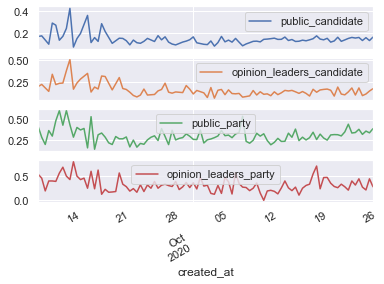

In [9]:
df.plot(subplots=True)

In [10]:
df.columns = ['cantidate', 'candidate_ol', 'party', 'party_ol']
df.to_csv('Data\\final_data.csv')